# Weakly Supervised Learning


## Setup


In [1]:
!nvidia-smi

Wed Sep 20 12:49:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 27%   39C    P5     8W / 180W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

In [3]:
pd.set_option("display.max_colwidth", None)

## Data Preprocessing


In [4]:
train = pd.read_json("../data/processed/train.json").drop(columns=['tweetid'])
train.head()

,text,label
0,«النيابة» تقدم 110 أدلة ضد 12 متهما في«خلية» فساد وظيفي عكاظ,0
1,تكدس مرورى أعلى كوبرى أكتوبر من مدينة نصر للمهندسين,1
2,RT : اذا ضفت احد جديد بسناب ودي اقوله لو سمحت عادي اوريك كل الصور والفيديوات الحلوه اللي طافتك؟؟؟,0
3,RT : تقبل الله الدعاء وصالح الأعمال يوم عرفه,0
4,RT : كشف تسربات المياه حل ارتفاع فتوره المياه عزل اسطح مبلطه وغير مبلطه عزل حمامات عزل خزانات المياه عزل اسطح رش مبيد…,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193813 entries, 0 to 196105
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    193813 non-null  object
 1   label   193813 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [6]:
train.label.value_counts(normalize=True)

0    0.628993
1    0.371007
Name: label, dtype: float64

In [7]:
test = pd.read_json("../data/processed/test_gold.json")[["text", "label"]]
test.head()

,text,label
0,شاركوا معنا .. في ساعة الأرض الليلة ساعة واحد فقط ( ٨:٣٠ - ٩:٣٠ ) مساهمة في التوعية بتوفير استهلاك الطاقة التدريب التقني نجران نجران الان المسؤولية الإجتماعية نطفىء الأضواء .. ليضيء الكوكب,0
1,RT : اللهم طهر قلوبنا من كل ضيق ويسر أمورنا في كل طريق مساء الخير,0
2,- 97 يوم . .,0
3,RT : ”اشتقت بصمت أتألم لأكن الله لطيف بـ القلوب عشق الزعامه للدعم قروب عشقي الزعيم قروب شقردي جنوبي,0
4,قالﷺ: (من كانت الآخرة همـــه جعل الله غناه في قلبـه وجمـع لـه شملــــه وأتته الدنيا وهي راغمة) صحيح الجامع ٦٥١٠,0


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    420 non-null    object
 1   label   420 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


In [9]:
test.label.value_counts()

0    380
1     40
Name: label, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_df, valid_df = train_test_split(train, stratify=train.label.to_list())
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [12]:
train_df.label.value_counts(normalize=True)

0    0.628994
1    0.371006
Name: label, dtype: float64

In [13]:
valid_df.label.value_counts(normalize=True)

0    0.628988
1    0.371012
Name: label, dtype: float64

In [14]:
test.label.value_counts(normalize=True)

0    0.904762
1    0.095238
Name: label, dtype: float64

In [15]:
lf_dev = pd.read_json("../data/processed/lf_dev.json")[["text", "label"]]
lf_dev.label.value_counts(normalize=True)

0    0.904
1    0.096
Name: label, dtype: float64

In [16]:
lf_dev = lf_dev.reset_index(drop=True)
test = test.reset_index(drop=True)

## Tokenization


In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02-twitter')

In [18]:
# transformimg from pandas to hugging face datasets

from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df, split="train")
valid_ds = Dataset.from_pandas(valid_df, split="validation")
lf_dev_ds = Dataset.from_pandas(lf_dev, split="lf_development")
test_ds = Dataset.from_pandas(test, split="test")

ds = DatasetDict({"train": train_ds, "validation": valid_ds,
                  "lf_development": lf_dev_ds, "test": test_ds})
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 145359
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 48454
    })
    lf_development: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 420
    })
})

In [19]:
def tokenize_ds(field):
    """Tokenize examples from dataset."""
    return tokenizer(
        field["text"],
        truncation=True,
    )

In [20]:
ds_encoded = ds.map(tokenize_ds, batched=True)

  0%|          | 0/146 [00:00<?, ?ba/s]

  0%|          | 0/49 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 145359
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 48454
    })
    lf_development: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
})

## Modeling


### Setup


In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [23]:
def compute_scores(preds):
    """Compute scores of transformers predictions."""
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred)
    prec = precision_score(labels, pred)
    rec = recall_score(labels, pred)
    return {"Accuracy": acc, 'Precision': prec, 'Recall': rec, "F1": f1}

In [24]:
id2label = {0: "transparent", 1: "propaganda"}
label2id = {"transparent": 0, "propaganda": 1}

In [25]:
from transformers import AutoModelForSequenceClassification, TrainingArguments

In [26]:
def model_init():
    return (AutoModelForSequenceClassification
            .from_pretrained('aubmindlab/bert-base-arabertv02-twitter',
                             num_labels=2, id2label=id2label,
                             label2id=label2id))

In [27]:
class CustomTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=1.0, beta=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.beta = beta

In [28]:
# training_args = CustomTrainingArguments(
#     output_dir="../models/arabertv2-prop",
#     learning_rate=2e-5,
#     per_device_train_batch_size=96,
#     per_device_eval_batch_size=128,
#     num_train_epochs=1,
#     weight_decay=1e-4,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     log_level="error",
#     push_to_hub=False,
# )

### Training


In [29]:
import torch
from torch import nn
from transformers import Trainer
import torch.nn.functional as F

# labels = train_df.label # np.argmax(train_df.label.to_list(), axis=-1)

# w0 = labels.sum() / len(labels)
# w1 = 1 - w0
# w = torch.tensor([w0, w1], device="cuda", dtype=torch.float32)
# w

In [30]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [31]:
# APL (Active Passive Loss)

class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()


class ReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(ReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))
        return self.scale * rce.mean()


class NCEandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandRCE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.rce(pred, labels)


class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        mae = 1. - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * mae.mean()


class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

In [32]:
# aploss = NCEandMAE(alpha=1.0, beta=10.0, num_classes=2)

In [33]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels") # [batch_size, num_labels]
        # del inputs['labels']
        outputs = model(**inputs)
        logits = outputs.get("logits") # [batch_size, num_labels]
        # loss_fct = nn.CrossEntropyLoss(weight=w_)
        # loss = loss_fct(
        #     logits.view(-1, self.model.config.num_labels), labels.view(-1))
        loss_fn = NCEandMAE(alpha=self.args.alpha, beta=self.args.beta, num_classes=2)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [34]:
# trainer = CustomTrainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=ds_encoded["train"],
#     eval_dataset=ds_encoded["validation"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_scores,
# )

In [35]:
# # hp tuning
# def hp_space(trial):
#     return {"alpha": trial.suggest_categorical("alpha", [0.01, 0.1, 1.0, 10]),
#             "beta": trial.suggest_categorical("beta", [0.01, 0.1, 1.0, 10])}

In [36]:
# def compute_objective(metrics):
#     return metrics["eval_F1"]

In [37]:
# best_run = trainer.hyperparameter_search(n_trials=3, direction="maximize",
#                                          compute_objective=compute_objective,
#                                          hp_space=hp_space, storage="sqlite:///optuna_apl.db")

In [38]:
# print(best_run)

In [39]:
# import json

# with open("./hp.json", "w+") as f:
#     json.dump(best_run.hyperparameters, f, indent=1)

In [40]:
# import json

# with open("./hp.json") as f:
#     best_run = json.load(f)

In [41]:
import json
import wandb

with open("../data/access_tokens.json") as f:
    login_key = json.load(f)["wandb"]["login"]

wandb.login(key=login_key)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [42]:
wandb.init(project="arabic-weak-propaganda", name="arabert-nce_mae")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [43]:
training_args = CustomTrainingArguments(
    output_dir="../models/arabertv2-prop",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=1e-5,
    warmup_ratio=0.1,
    alpha=1.0, beta=1.0,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    log_level="error",
)

In [44]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [45]:
trainer = CustomTrainer(
    model=model_init(),
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [46]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.368900,0.376332,0.811780,0.818483,0.633087,0.713945
2,0.332300,0.376210,0.811863,0.698384,0.867609,0.773853
3,0.339500,0.359793,0.820097,0.801589,0.684541,0.738456
4,0.320700,0.331806,0.834131,0.776973,0.775547,0.776259
5,0.306100,0.324861,0.837599,0.780466,0.782333,0.781398


TrainOutput(global_step=11360, training_loss=0.34907602390772857, metrics={'train_runtime': 7394.0061, 'train_samples_per_second': 98.295, 'train_steps_per_second': 1.536, 'total_flos': 2.390861742006786e+16, 'train_loss': 0.34907602390772857, 'epoch': 5.0})

In [47]:
trainer.evaluate(ds_encoded["lf_development"], metric_key_prefix="lf_development")

{'lf_development_loss': 0.16800065338611603,
 'lf_development_Accuracy': 0.916,
 'lf_development_Precision': 0.5789473684210527,
 'lf_development_Recall': 0.4583333333333333,
 'lf_development_F1': 0.5116279069767442,
 'lf_development_runtime': 1.5834,
 'lf_development_samples_per_second': 315.785,
 'lf_development_steps_per_second': 5.053,
 'epoch': 5.0}

In [48]:
outs = trainer.predict(ds_encoded["lf_development"])
preds = np.argmax(outs[0], axis=-1)
labels = outs[1]

In [49]:
label_names = list(label2id.keys())

In [50]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 transparent       0.94      0.96      0.95       452
  propaganda       0.58      0.46      0.51        48

    accuracy                           0.92       500
   macro avg       0.76      0.71      0.73       500
weighted avg       0.91      0.92      0.91       500



In [51]:
sns.set_style("whitegrid", {'axes.grid': False})

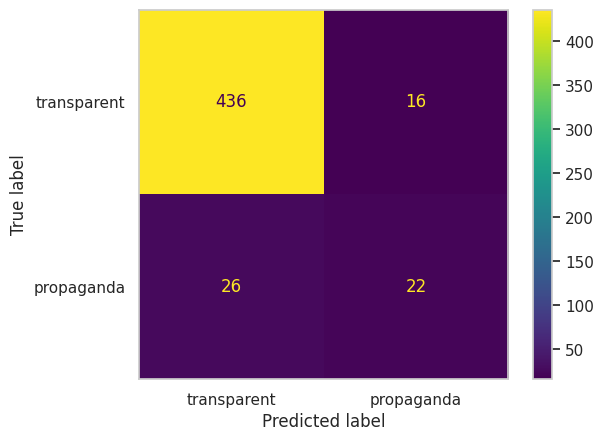

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)


disp.plot()
plt.show()

In [53]:
trainer.evaluate(ds_encoded["test"], metric_key_prefix="test")

{'test_loss': 0.15167336165905,
 'test_Accuracy': 0.9238095238095239,
 'test_Precision': 0.6052631578947368,
 'test_Recall': 0.575,
 'test_F1': 0.5897435897435896,
 'test_runtime': 1.5784,
 'test_samples_per_second': 266.093,
 'test_steps_per_second': 4.435,
 'epoch': 5.0}

In [54]:
outs = trainer.predict(ds_encoded["test"])
preds = np.argmax(outs[0], axis=-1)
labels = outs[1]

In [55]:
print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 transparent       0.96      0.96      0.96       380
  propaganda       0.61      0.57      0.59        40

    accuracy                           0.92       420
   macro avg       0.78      0.77      0.77       420
weighted avg       0.92      0.92      0.92       420



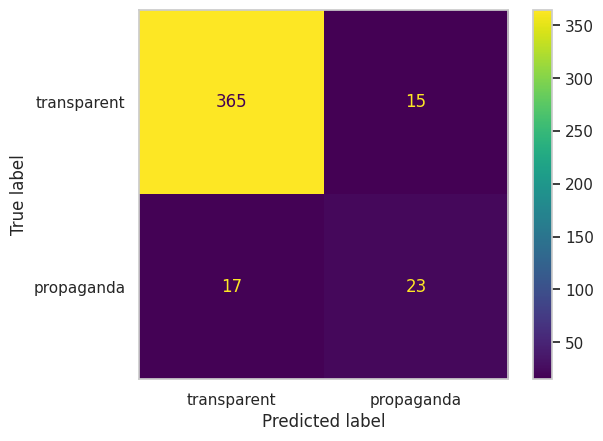

In [56]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot()
plt.show()

In [57]:
trainer.save_model("../models/arabertv2-prop")

In [58]:
wandb.finish()

eval/Accuracy,▁▁▃▇█
eval/F1,▁▇▄▇█
eval/Precision,█▁▇▆▆
eval/Recall,▁█▃▅▅
eval/loss,██▆▂▁
eval/runtime,▁▄▆█▂
eval/samples_per_second,█▅▃▁▇
eval/steps_per_second,█▅▃▁▇
test/Accuracy,▁
test/F1,▁
test/Precision,▁
